In [44]:
import mysql.connector

connection = mysql.connector.connect(
    host="NF-inventory.cdgk6g4o2kj5.ca-central-1.rds.amazonaws.com",
    port=3306,
    user="chriso124",
    password="DuKNWv8dcUI27q7bCz7A",
    database="nf_inventory" 
)
cursor = connection.cursor()

cursor.execute("""
CREATE TABLE Products (
    id INT AUTO_INCREMENT PRIMARY KEY,
    article_number varchar(50) NOT NULL,
    description VARCHAR(255) NOT NULL,
    department VARCHAR(100) NOT NULL,
    category VARCHAR(100) NOT NULL
);
""")

cursor.execute("""
CREATE TABLE DailyCheckIn (
    id INT AUTO_INCREMENT PRIMARY KEY,
    product_id INT NOT NULL,
    inventory FLOAT NOT NULL,
    weekday TINYINT NOT NULL CHECK (weekday BETWEEN 0 AND 6),
    week TINYINT NOT NULL CHECK (week BETWEEN 0 AND 51),
    year SMALLINT NOT NULL,
    FOREIGN KEY (product_id) REFERENCES Products(id)
);
""")

connection.commit()
print("Tables created successfully.")
cursor.close()


Tables created successfully.


True

In [42]:
import pandas as pd
import mysql.connector
from datetime import datetime
from tkinter import filedialog

# Step 1: Load and Filter Excel File
file_path = filedialog.askopenfilename(filetypes=[("Excel Workbooks", "*.xlsx")])
if file_path:
    # Read Excel file
    df = pd.read_excel(file_path, engine='openpyxl')

    # Filter relevant columns
    columns = ['Department', 'Merchandise Category', 'Article Description', 'Article', 'Inventory']
    filtered_df = df[columns]

    # Connect to MySQL Database
    connection = mysql.connector.connect(
        host="NF-inventory.cdgk6g4o2kj5.ca-central-1.rds.amazonaws.com",
        port=3306,
        user="chriso124",  # Add your username
        password="DuKNWv8dcUI27q7bCz7A",  # Add your password
        database="nf_inventory"  # Replace with your database name
    )
    cursor = connection.cursor()
    # Step 2: Process Data
    for _, row in filtered_df.iterrows():
        # Extract data
        department = row['Department']
        category = row['Merchandise Category']
        description = row['Article Description']
        article = row['Article']
        inventory = row['Inventory']

        # Check if article exists in the Products table
        cursor.execute("SELECT id FROM Products WHERE article_number = %s", (article,))
        product = cursor.fetchone()

        if not product:
            # If article doesn't exist, insert into Products and log description
            cursor.execute("""
                INSERT INTO Products (article_number, description, department, category)
                VALUES (%s, %s, %s, %s)
            """, (article, description, department, category))
            connection.commit()
            print(f"Added new product: {description}")

            # Retrieve the new product ID
            cursor.execute("SELECT id FROM Products WHERE article_number = %s", (article,))
            product = cursor.fetchone()

        product_id = product[0]  # Extract the product ID

        # Step 3: Insert into DailyCheckIn
        today = datetime.now()
        weekday = today.weekday()  # 0 = Monday, 6 = Sunday
        week = today.isocalendar()[1] - 1  # Week number (adjust if needed)
        year = today.year

        cursor.execute("""
            INSERT INTO DailyCheckIn (product_id, inventory, weekday, week, year)
            VALUES (%s, %s, %s, %s, %s)
        """, (product_id, inventory, weekday, week, year))
        connection.commit()

    # Close the connection
    cursor.close()
    connection.close()

    print("Data has been processed and inserted into the database.")



[('information_schema',), ('mysql',), ('new_db_name',), ('performance_schema',), ('sys',)]
('information_schema',)
('mysql',)
('new_db_name',)
('performance_schema',)
('sys',)


In [5]:
import psycopg2
import json
# Database connection configuration
db_config = json.load(open('config.json'))

try:
    # Connect to the database
    connection = psycopg2.connect(**db_config)
    cursor = connection.cursor()

    # SQL query to select all rows from DailyCheckIn
    query = "SELECT * FROM DailyCheckIn;"
    query = 'SELECT * FROM PRODUCTS'
    cursor.execute(query)

    # Fetch and print all results
    results = cursor.fetchall()
    for row in results:
        print(row)

except psycopg2.Error as err:
    print(f"Error: {err}")

finally:
    if connection:
        cursor.close()
        connection.close()
        print("Connection closed.")


(1, '21571862', 'MMS PN PGPK AF RSU', 'Grocery', 'Chocolate', True)
(2, '21305889', 'GLDE PISO STARTER PINE WNDRLND', 'Grocery', 'Air Fresheners', True)
(3, '21498511', 'GLADE SPRING JAR CANDLE WTRMLN', 'Grocery', 'Air Fresheners', True)
(4, '21574214', 'GLADE PISO REF MELON', 'Grocery', 'Air Fresheners', True)
(5, '21574274', 'FEBR AIR GAPEACHORC', 'Grocery', 'Air Fresheners', True)
(6, '21574301', 'GLADE PISO REF MINT', 'Grocery', 'Air Fresheners', True)
(7, '20124109001', 'AIRWICK FM MOUNTAIN BREEZE', 'Grocery', 'Air Fresheners', True)
(8, '21354625', 'PCBL SYRUP LEMON SOUR', 'Grocery', 'Alternative Beverage', True)
(9, '21357037', 'GATORADE ZERO FRUIT PUNCH', 'Grocery', 'Alternative Beverage', True)
(10, '21403389', 'PC WINE DEALC SAUVIGNON BLANC', 'Grocery', 'Alternative Beverage', True)
(11, '21547829', 'RDBL WINTER FIG APPLE', 'Grocery', 'Alternative Beverage', True)
(12, '21588266', 'PC DE ALC APPLE CIDER', 'Grocery', 'Alternative Beverage', True)
(13, '21643283', 'LF DRINK MIX

In [24]:
from datetime import datetime

# Current date and time
today = datetime.now()

# Calculate weekday
# 0 = Monday, 6 = Sunday
weekday = today.weekday()

# Calculate ISO week number
# Returns a tuple (year, week_number, weekday)
week_number = today.isocalendar()[1] # Adjust week number to 0-based indexing

# Current year
year = today.year

print(f"Today is weekday: {weekday}, week number: {week_number}, year: {year}")


Today is weekday: 1, week number: 2, year: 2025


In [ ]:
import os
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import mysql.connector
from datetime import datetime

from tkinter import ttk  # For the Progressbar

# -----------------------------------------------------------------------
# NEW CLASS: SendInventoryPipeline
# -----------------------------------------------------------------------
class InventoryPipeline(tk.Toplevel):
    """
    Toplevel window to send the DataFrame's inventory to MySQL row-by-row,
    displaying a progress bar and logging newly discovered products 
    in a text box.

    If auto_mode=True, we won't actually show this window. Instead, 
    we do the insertion quietly (used on close_app).
    """
    def __init__(self, master, df_inventory, db_config, parent_app, auto_mode=False, *args, **kwargs):
        super().__init__(master, *args, **kwargs)
        self.master = master
        self.parent_app = parent_app
        self.df_inventory = df_inventory
        self.db_config = db_config
        self.auto_mode = auto_mode

        # If auto_mode is False, we build the GUI
        if not self.auto_mode:
            self.title("Sending Inventory to Server")
            self.geometry("500x400")

            self.progress_label = ttk.Label(self, text="Progress:")
            self.progress_label.pack(pady=(15,0))

            self.progress_bar = ttk.Progressbar(self, orient="horizontal", length=400, mode="determinate")
            self.progress_bar.pack(pady=5)

            # A text box to log newly discovered products
            self.log_text = tk.Text(self, width=60, height=12)
            self.log_text.pack(pady=10)

        # Start the pipeline
        self.after(100, self.send_data_to_mysql)

    def send_data_to_mysql(self):
        total_rows = len(self.df_inventory)
        progress_val = 0

        # Connect to MySQL
        conn = mysql.connector.connect(**self.db_config)
        cur = conn.cursor()

        try:
            # For each row in the DataFrame
            for i, row in self.df_inventory.iterrows():
                department   = row.get("Department", "")
                category     = row.get("Merchandise Category", "")
                description  = row.get("Article Description", "")
                article      = row.get("Article", None)
                inventory    = row.get("Inventory", None)

                if pd.isna(article):
                    continue

                # Check if article exists
                cur.execute("SELECT id FROM Products WHERE article_number = %s", (article,))
                product = cur.fetchone()

                if not product:
                    # Insert as new product
                    cur.execute("""
                        INSERT INTO Products (article_number, description, department, category)
                        VALUES (%s, %s, %s, %s)
                    """, (article, description, department, category))
                    conn.commit()
                    # Retrieve the new product ID
                    cur.execute("SELECT id FROM Products WHERE article_number = %s", (article,))
                    product = cur.fetchone()

                    # Log newly discovered product in the text box
                    if not self.auto_mode:
                        self.log_text.insert(tk.END, f"New product discovered: {article}\n")
                        self.log_text.see(tk.END)

                product_id = product[0]

                # Insert a row into DailyCheckIn
                today = datetime.now()
                weekday = today.weekday()  # 0=Mon, 6=Sun
                week = today.isocalendar()[1] - 1
                year = today.year

                cur.execute("""
                    INSERT INTO DailyCheckIn (product_id, inventory, weekday, week, year)
                    VALUES (%s, %s, %s, %s, %s)
                """, (product_id, inventory, weekday, week, year))
                conn.commit()

                # Update progress
                progress_val += 1
                if not self.auto_mode:
                    self.progress_bar['value'] = progress_val
                    self.progress_bar['maximum'] = total_rows
                    if total_rows > 0:
                        pct = int((progress_val / total_rows) * 100)
                        self.progress_label.config(text=f"Progress: {pct}%")
                    self.update_idletasks()

        except mysql.connector.Error as e:
            messagebox.showerror("MySQL Error", str(e), parent=self.master)
        finally:
            cur.close()
            conn.close()

        # Mark parent's "sent_to_mysql" as True
        self.parent_app.sent_to_mysql = True
        # Disable the parent's "Send Inventory to Server" button
        self.parent_app.send_to_server_btn.config(state=tk.DISABLED)

        if not self.auto_mode:
            messagebox.showinfo("Done", "Inventory has been successfully sent!", parent=self)
            self.destroy()
        else:
            # If in auto_mode, just destroy silently
            self.destroy()



In [3]:
"""
scratch_delete_article.py

A simple standalone script to delete an article from the 'Products' table.
"""

import mysql.connector

# 1) Update the connection details to match your setup
DB_CONFIG = json.load(open('config.json'))

def delete_article(article_number):
    """
    Deletes the given article_number from the Products table.
    """
    conn = None
    cur = None

    try:
        # 2) Connect to MySQL
        conn = mysql.connector.connect(**DB_CONFIG)
        cur = conn.cursor()
        
        # 3) Execute the DELETE statement
        delete_query = "DELETE FROM Products WHERE article_number = %s"
        cur.execute(delete_query, (article_number,))
        conn.commit()

        # 4) Check how many rows were affected
        if cur.rowcount > 0:
            print(f"✓ Article {article_number} was successfully deleted.")
        else:
            print(f"✗ Article {article_number} not found in the database.")

    except mysql.connector.Error as err:
        print(f"MySQL error: {err}")
    finally:
        # 5) Clean up
        if cur:
            cur.close()
        if conn:
            conn.close()

if __name__ == "__main__":
    # 6) For quick testing, edit this article_number or fetch from user input
    article_id_to_delete = '20695204'
    delete_article(article_id_to_delete)


MySQL error: 1451 (23000): Cannot delete or update a parent row: a foreign key constraint fails (`nf_inventory`.`DailyCheckIn`, CONSTRAINT `DailyCheckIn_ibfk_1` FOREIGN KEY (`product_id`) REFERENCES `Products` (`id`))


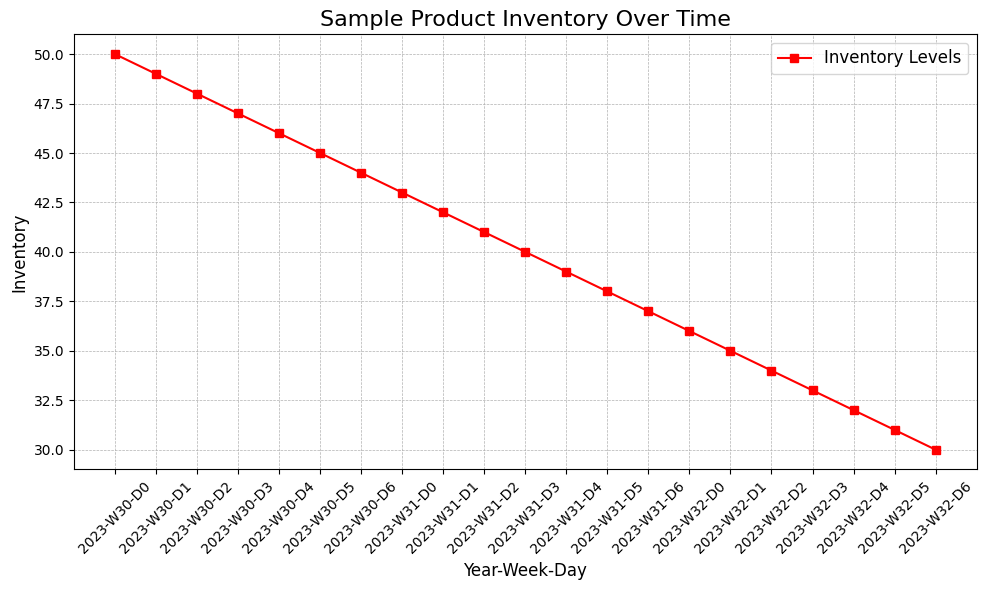

<Figure size 640x480 with 0 Axes>

In [5]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Sample data for demonstration
data = {
    "x_labels": [f"2023-W{i}-D{j}" for i in range(30, 33) for j in range(0, 7)],
    "y_inventories": [50 - i for i in range(21)]  # Sample inventory levels
}

# Convert to DataFrame for flexibility
df = pd.DataFrame(data)

# Plot the time series
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(
    df["x_labels"], 
    df["y_inventories"], 
    marker='s',  # Square markers
    linestyle='-', 
    color='red',  # Red line
    label="Inventory Levels"
)
plt.title("Sample Product Inventory Over Time", fontsize=16)
plt.xlabel("Year-Week-Day", fontsize=12)
plt.ylabel("Inventory", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid
plt.tight_layout()
plt.show()


# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [24]:
#SET UP DNO DATABASE ON SERVER
import psycopg2

# Database connection details
DB_CONFIG = json.load(open('config.json'))

# Function to connect to PostgreSQL
def connect_to_postgresql():
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        print("Connected to PostgreSQL successfully!")
        return conn
    except psycopg2.Error as e:
        print(f"Failed to connect to PostgreSQL: {e}")
        return None

# Function to create the dno table
def create_dno_table(conn):
    try:
        with conn.cursor() as cur:
            cur.execute("""
            CREATE TABLE IF NOT EXISTS dno (
                id SERIAL PRIMARY KEY,
                article VARCHAR(25) UNIQUE NOT NULL,
                active BOOLEAN DEFAULT TRUE
            );
            """)
            conn.commit()
            print("dno table created successfully!")
    except psycopg2.Error as e:
        print(f"Error creating dno table: {e}")

conn = connect_to_postgresql()
create_dno_table(conn)


Connected to PostgreSQL successfully!
dno table created successfully!


In [3]:
#SETTING UP THE PRODUCT HISTORY DB ON SERVER


import psycopg2

# Database connection configuration
db_config = json.load(open('config.json'))

def recreate_tables():
    try:
        # Connect to PostgreSQL
        conn = psycopg2.connect(**db_config)
        cur = conn.cursor()

        # Drop the tables if they exist
        print("Dropping tables if they exist...")
        cur.execute("DROP TABLE IF EXISTS DailyCheckIn CASCADE;")
        cur.execute("DROP TABLE IF EXISTS Products CASCADE;")

        # Recreate the Products table
        print("Recreating Products table...")
        cur.execute("""
        CREATE TABLE Products (
            id SERIAL PRIMARY KEY,
            article_number VARCHAR(25) UNIQUE NOT NULL,
            description VARCHAR(50),
            department VARCHAR(25),
            category VARCHAR(25),
            active BOOLEAN DEFAULT TRUE
        );
        """)

        # Recreate the DailyCheckIn table
        print("Recreating DailyCheckIn table...")
        cur.execute("""
        CREATE TABLE DailyCheckIn (
            id SERIAL PRIMARY KEY,
            product_id INT UNIQUE NOT NULL,
            year SMALLINT NOT NULL,  -- Year as a small integer (e.g., 2023)
            week SMALLINT NOT NULL,  -- Week number (0–52)
            D0_inventory INT,        -- Inventory for Day 0 (Monday)
            D1_inventory INT,        -- Inventory for Day 1 (Tuesday)
            D2_inventory INT,        -- Inventory for Day 2 (Wednesday)
            D3_inventory INT,        -- Inventory for Day 3 (Thursday)
            D4_inventory INT,        -- Inventory for Day 4 (Friday)
            D5_inventory INT,        -- Inventory for Day 5 (Saturday)
            D6_inventory INT,        -- Inventory for Day 6 (Sunday)
            FOREIGN KEY (product_id) REFERENCES Products (id) ON DELETE CASCADE,
            CONSTRAINT unique_product_week UNIQUE (product_id, year, week)
        );
        """)

        # Commit changes
        conn.commit()
        print("Tables Products and DailyCheckIn have been successfully recreated with numeric week and year.")

    except psycopg2.Error as e:
        print(f"Error: {e}")

    finally:
        if conn:
            cur.close()
            conn.close()
            print("Connection closed.")

if __name__ == "__main__":
    recreate_tables()


Dropping tables if they exist...
Recreating Products table...
Recreating DailyCheckIn table...
Tables Products and DailyCheckIn have been successfully recreated with numeric week and year.
Connection closed.


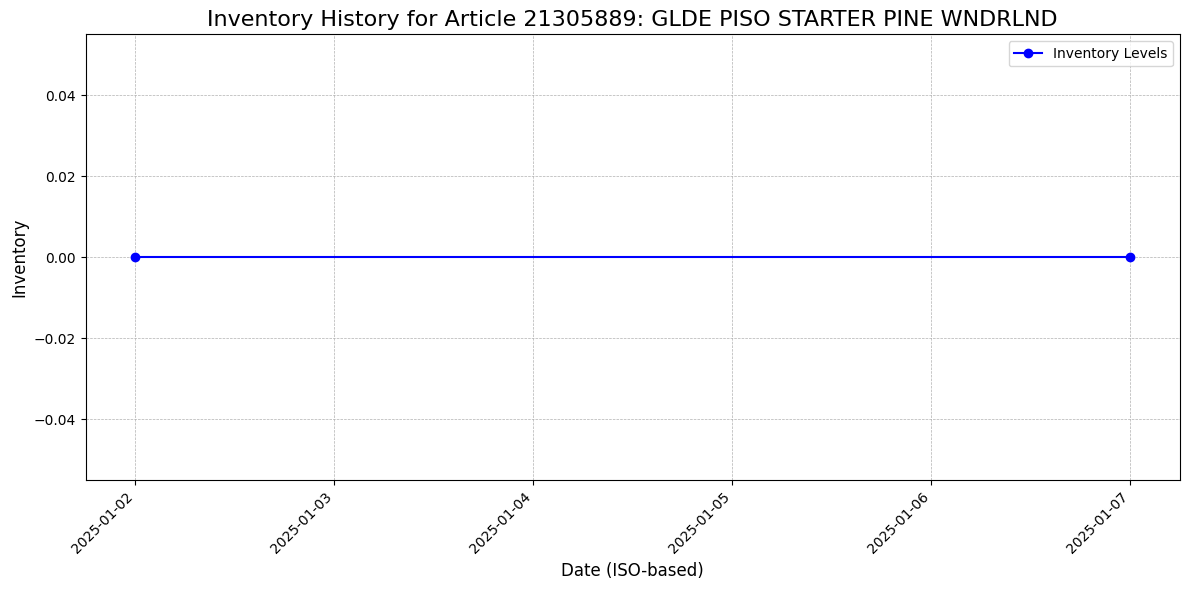

In [12]:
#!/usr/bin/env python3
# iso_based_timeseries.py

import psycopg2
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import matplotlib.dates as mdates

# ------------------------------------------------------------------------------
# 1. Database configuration
# ------------------------------------------------------------------------------
db_config = json.load(open('config.json'))

# ------------------------------------------------------------------------------
# 2. Convert (ISO year, ISO week, ISO day=1..7) to a date
# ------------------------------------------------------------------------------
def iso_to_date(iso_year: int, iso_week: int, iso_day: int) -> date:
    """
    Convert an ISO year-week-day combination (e.g. 2025, 2, 2)
    into a Python date object (2025-01-07).

      - iso_year: The ISO-8601 year (which can differ from calendar year near boundaries).
      - iso_week: The ISO week number (1..53).
      - iso_day:  1=Monday .. 7=Sunday (ISO-8601).

    Returns:
        A datetime.date object representing the actual (Gregorian) date.
    """
    # Step 1: January 4 is always in ISO week 1.
    january_4 = date(iso_year, 1, 4)

    # Step 2: Find Monday of ISO week 1
    #   isoweekday() => Monday=1, Tuesday=2, ..., Sunday=7.
    #   Subtract (january_4.isoweekday() - 1) days to get that Monday.
    first_monday = january_4 - timedelta(days=january_4.isoweekday() - 1)

    # Step 3: From that Monday, move forward (iso_week - 1) weeks
    #         plus (iso_day - 1) days.
    return first_monday + timedelta(weeks=(iso_week - 1), days=(iso_day - 1))

# ------------------------------------------------------------------------------
# 3. Fetch time-series data from PostgreSQL
# ------------------------------------------------------------------------------
def fetch_time_series(article_id, start_week, end_week):
    """
    Fetches inventory data from the database for the specified article
    and week range. Returns (rows, product_description, article_id).

    Each row in 'rows' will look like:
      (year, week, D0, D1, D2, D3, D4, D5, D6)
    where D0 is Monday’s inventory, D6 is Sunday’s.
    """
    conn = None
    try:
        conn = psycopg2.connect(
            host=db_config['host'],
            dbname=db_config['dbname'],
            user=db_config['user'],
            password=db_config['password'],
            port=db_config['port']
        )
        cur = conn.cursor()

        # 1) Fetch product description
        cur.execute(
            "SELECT description FROM Products WHERE article_number = %s",
            (article_id,)
        )
        description_result = cur.fetchone()
        if not description_result:
            print(f"No product found for Article ID: {article_id}")
            return None, None, None
        product_description = description_result[0]

        # 2) Fetch time-series data
        sql_query = """
        SELECT DC.year, DC.week, DC.D0_inventory, DC.D1_inventory, DC.D2_inventory,
               DC.D3_inventory, DC.D4_inventory, DC.D5_inventory, DC.D6_inventory
        FROM DailyCheckIn AS DC
        JOIN Products AS P ON DC.product_id = P.id
        WHERE P.article_number = %s
          AND DC.week >= %s
          AND DC.week <= %s
        ORDER BY DC.year, DC.week
        """
        cur.execute(sql_query, (article_id, start_week, end_week))
        rows = cur.fetchall()

        return rows, product_description, article_id

    except psycopg2.Error as e:
        print(f"Database error: {e}")
        return None, None, None
    finally:
        if conn:
            conn.close()

# ------------------------------------------------------------------------------
# 4. Plot the time series (using iso_to_date)
# ------------------------------------------------------------------------------
def plot_time_series(rows, product_description, article_id):
    """
    rows is a list of tuples: (iso_year, iso_week, D0, D1, D2, D3, D4, D5, D6)
      where D0 corresponds to Monday's inventory (iso_day=1),
      D1 => Tuesday (iso_day=2), etc.

    We'll:
      1) Convert each non-None inventory to (date, inventory).
      2) Sort by date.
      3) Plot, deciding on daily vs. weekly labeling based on total days spanned.
    """
    if not rows:
        print("No data to plot.")
        return

    all_dates = []
    all_inventories = []

    # Convert each row to potential 7 daily data points
    for (yr, wk, D0, D1, D2, D3, D4, D5, D6) in rows:
        daily_invs = [D0, D1, D2, D3, D4, D5, D6]
        for day_num, inv in enumerate(daily_invs):
            if inv is None:
                continue
            # day_num=0 => Monday => iso_day=1
            # day_num=1 => Tuesday => iso_day=2
            iso_day = day_num + 1  # map 0..6 -> 1..7
            dt = iso_to_date(yr, wk, iso_day)
            all_dates.append(dt)
            all_inventories.append(inv)

    if not all_dates:
        print("No valid data to plot after filtering None.")
        return

    # Sort by the date
    paired = sorted(zip(all_dates, all_inventories), key=lambda x: x[0])
    plot_dates, plot_values = zip(*paired)

    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(plot_dates, plot_values, marker='o', linestyle='-', color='blue',
            label="Inventory Levels")

    ax.set_title(f"Inventory History for Article {article_id}: {product_description}", fontsize=16)
    ax.set_xlabel("Date (ISO-based)", fontsize=12)
    ax.set_ylabel("Inventory", fontsize=12)

    # Decide daily vs. weekly tick labeling based on total range
    day_span = (plot_dates[-1] - plot_dates[0]).days
    if day_span <= 14:
        # Label every day
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    else:
        # Label weekly (on Mondays) or use AutoDateLocator
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotate tick labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Grid lines
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 5. Example usage (adjust article_id, start_week, end_week as needed)
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    article_id = "21305889"
    start_week = 0
    end_week = 2

    rows, description, article_id = fetch_time_series(article_id, start_week, end_week)
    plot_time_series(rows, description, article_id)


In [9]:
import json
import psycopg2

# Database connection configuration
db_config = json.load(open('config.json'))
def list_column_info():
    try:
        # Connect to the database
        connection = psycopg2.connect(**db_config)
        cursor = connection.cursor()

        # Query for column information
        query = """
            SELECT
                table_name,
                column_name,
                data_type,
                is_nullable,
                character_maximum_length,
                column_default
            FROM
                information_schema.columns
            WHERE
                table_schema = 'public'
            ORDER BY
                table_name, ordinal_position;
        """
        cursor.execute(query)

        # Fetch and print results
        results = cursor.fetchall()
        print("Column Information for Tables:")
        for row in results:
            print(f"Table: {row[0]}, Column: {row[1]}, Type: {row[2]}, "
                  f"Nullable: {row[3]}, Max Length: {row[4]}, Default: {row[5]}")

    except psycopg2.Error as err:
        print(f"Error: {err}")

    finally:
        if connection:
            cursor.close()
            connection.close()
            print("Connection closed.")

if __name__ == "__main__":
    list_column_info()


Column Information for Tables:
Table: dailycheckin, Column: product_id, Type: integer, Nullable: NO, Max Length: None, Default: None
Table: dailycheckin, Column: year, Type: smallint, Nullable: NO, Max Length: None, Default: None
Table: dailycheckin, Column: week, Type: smallint, Nullable: NO, Max Length: None, Default: None
Table: dailycheckin, Column: d0_inventory, Type: real, Nullable: YES, Max Length: None, Default: None
Table: dailycheckin, Column: d1_inventory, Type: real, Nullable: YES, Max Length: None, Default: None
Table: dailycheckin, Column: d2_inventory, Type: real, Nullable: YES, Max Length: None, Default: None
Table: dailycheckin, Column: d3_inventory, Type: real, Nullable: YES, Max Length: None, Default: None
Table: dailycheckin, Column: d4_inventory, Type: real, Nullable: YES, Max Length: None, Default: None
Table: dailycheckin, Column: d5_inventory, Type: real, Nullable: YES, Max Length: None, Default: None
Table: dailycheckin, Column: d6_inventory, Type: real, Nullab

In [10]:
"""
iso_day_of_year.py

Demonstrates how to:
  1) Convert an ISO date (iso_year, iso_week, iso_day) to a Python date
  2) Compute the day of year for that real calendar date
"""

from datetime import date, timedelta

def iso_to_date(iso_year: int, iso_week: int, iso_day: int) -> date:
    """
    Convert an ISO year-week-day combination (e.g. 2025, 2, 2)
    into a Python date object (2025-01-07).

      - iso_year: The ISO-8601 year (which can differ from the calendar year near boundaries)
      - iso_week: The ISO week number (1..53)
      - iso_day:  The ISO weekday (1=Monday .. 7=Sunday)

    Returns:
        A datetime.date object representing the actual (Gregorian) date.
    """
    # Step 1: January 4 is always in ISO week 1 of iso_year
    january_4 = date(iso_year, 1, 4)

    # Step 2: Monday of ISO week 1
    # isoweekday() => Monday=1, Tuesday=2, ... Sunday=7
    # Subtract (january_4.isoweekday() - 1) days to get that Monday
    first_monday = january_4 - timedelta(days=january_4.isoweekday() - 1)

    # Step 3: From that Monday, move forward (iso_week - 1) weeks and (iso_day - 1) days
    #         iso_day = 1 => Monday, iso_day = 7 => Sunday
    return first_monday + timedelta(weeks=(iso_week - 1), days=(iso_day - 1))


def iso_day_of_year(iso_year: int, iso_week: int, iso_day: int) -> int:
    """
    Given an ISO date (iso_year, iso_week, iso_day),
    return its day of year (1..365 or 366 in a leap year).
    """
    actual_date = iso_to_date(iso_year, iso_week, iso_day)
    # (actual_date.year, 1, 1) is January 1 of the *Gregorian* year in which actual_date falls
    day_of_year = (actual_date - date(actual_date.year, 1, 1)).days + 1
    return day_of_year


def main():
    # Example 1: Jan 7, 2025 is Tuesday of ISO week 2 => (2025, 2, 2)
    iso_year = 2025
    iso_week = 2
    iso_day = 2  # 1=Mon, 2=Tue, ... 7=Sun

    actual_date = iso_to_date(iso_year, iso_week, iso_day)
    print(f"ISO {iso_year}-W{iso_week}-D{iso_day} => date: {actual_date.isoformat()}")

    doy = iso_day_of_year(iso_year, iso_week, iso_day)
    print(f"Day of year for {actual_date.isoformat()} is {doy}.\n")

    # Example 2: ISO year boundary case:
    # Dec 29, 2024 might be in ISO week 1 of 2025 if it falls after the last Thursday of 2024
    # Let's check 2024-12-29 in terms of ISO
    # We do the reverse: by picking iso_week=1, iso_day=1 => Monday of ISO week 1 for 2025
    # might or might not be in late 2024.
    boundary_iso_year = 2025
    boundary_iso_week = 0
    boundary_iso_day = 1  # Monday
    boundary_date = iso_to_date(boundary_iso_year, boundary_iso_week, boundary_iso_day)
    print(f"ISO {boundary_iso_year}-W{boundary_iso_week}-D{boundary_iso_day} => "
          f"date: {boundary_date.isoformat()}")
    print(f"Day of year for {boundary_date.isoformat()} is "
          f"{iso_day_of_year(boundary_iso_year, boundary_iso_week, boundary_iso_day)}.")


if __name__ == "__main__":
    main()


ISO 2025-W2-D2 => date: 2025-01-07
Day of year for 2025-01-07 is 7.

ISO 2025-W0-D1 => date: 2024-12-23
Day of year for 2024-12-23 is 358.
